# Web Scraping and Introductory Data Analysis
bla bla bla

## Part 1: Web Scraping 

In [44]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
import time


In [45]:
WEB_URL = "https://etherscan.io/txs"
TRX_TABLE_XPATH_HEAD = "//table[@class='table table-hover table-align-middle mb-0']/thead/tr/th"
TRX_TABLE_XPATH_BODY = "//table[@class='table table-hover table-align-middle mb-0']/tbody/tr"
ETHER_SCAN_CSV_FILE = "etherscan.csv"
NUM_OF_BLOCKS = 10


We begin by initializing a WebDriver using Selenium. Specifically, we use the Firefox WebDriver to instantiate a Firefox browser instance. This WebDriver will facilitate interactions with web elements. The WebDriver navigates to the [Etherscan.io](https://etherscan.io/txs).  
An assertion is used to verify that the title of the webpage contains the keyword "Ethereum". This step ensures that the WebDriver successfully loaded the expected webpage.  
Also it is good to mention that the webdriver will wait for a page to load by default via .get() method before attempting to scrape the data.

In [46]:
driver = webdriver.Firefox()
def setupWebDriver():
    driver.get(WEB_URL)
    assert "Ethereum" in driver.title

setupWebDriver()

The getTrxTableHeaders function extracts transactions table headers from HTML source code using the table's id. It modifies the extracted headers to match a specific format and returns the modified header as a list.  
The getTrxTableBody function extracts the body of a transaction table from HTML source code using Beautiful Soup. It iterates through each row of the table, extracts the text from each cell, removes newline characters. Additionally, it captures the block number from the first row of the table. 

In [47]:
def getTrxTableHeaders(html_src):
    trx_table_head = html_src.find(id = "ContentPlaceHolder1_theadAllTransactionTable").find_all('th')
    header = [header.get_text().replace("\n", "") for header in trx_table_head]
    header[2] = "Method"
    header.pop(0)
    header.pop(5)
    header.insert(3, "Date")
    header.insert(5, "Local Time")
    header.append("Gas Price")
    return header

def getTrxTableBody(rows_elements, html_src):
    trx_table_body = html_src.find('table')
    trx_table_body = trx_table_body.find_all('tr')
    block_number = 0
    for i in range(1, len(trx_table_body)):
        rows = trx_table_body[i].find_all('td')
        element = [elem.get_text() for elem in rows]
        element = list(map(lambda x: x.replace("\n", ""), element))
        element.pop(8)
        element.pop(0)
        if i == 1:
            block_number = int(element[2])
        rows_elements.append(element)
    return rows_elements, block_number

In this part we iterate through the transaction table, continuously fetching data until a certain condition is met. We click on the "Next" button in order to implement pagination handling to navigate through the pages and collect the last 10 blocks' transactions data. In this case that certain condition is the block number; At each iteration we get the first row's block number and compare it to the latest block number that we have.  
In the end we save the data into a DataFrame.

In [48]:
def saveTransactionsToDp(header, body):
    transactionsDf = pd.DataFrame(body, columns=header)
    transactionsDf.to_csv(ETHER_SCAN_CSV_FILE, mode='a', header=False, index=False)
    return transactionsDf
    
def scrapeWebPage():
    html_src = BeautifulSoup(driver.page_source, 'html.parser')
    header = getTrxTableHeaders(html_src)
    rows_elements = []
    body, latest_block_number = getTrxTableBody(rows_elements, html_src)
    while True:
        html_src = BeautifulSoup(driver.page_source, 'html.parser')
        body, block_number = getTrxTableBody(body, html_src)
        next_button = driver.find_element(By.XPATH, '//a[@aria-label="Next"]')
        time.sleep(0.2)
        next_button.click()
        if block_number == latest_block_number - NUM_OF_BLOCKS:
            break
    transactionsDf = saveTransactionsToDp(header, body)
    driver.close()
    return latest_block_number, transactionsDf


In [49]:
latest_block_number, transactionsDf = scrapeWebPage()
def saveToCsvFile(transactionsDf):
    transactionsDf.to_csv(ETHER_SCAN_CSV_FILE, index=False)
    
saveToCsvFile(transactionsDf)

## Part 2: Data Analysis

#### Clean Transactions Data

In [50]:
transactionsDf_raw = transactionsDf.copy()

In [51]:
display(transactionsDf)

,Txn Hash,Method,Block,Date,Age,Local Time,From,To,Value,Txn Fee,Gas Price
0,0x78d28539fa6bafafa693ab3e88f0d69f1d76b7309e09...,Transfer,19398639,2024-03-09 16:08:59,16 secs ago,1710000539,builder0x69.eth,Lido: Execution Layer Rewards Vault,0.055852458 ETH,0.00166325,75.22307817
1,0x51139f42abe61475f05b79f25047fd0917769de90ba6...,Approve,19398639,2024-03-09 16:08:59,16 secs ago,1710000539,0x72ebAF6D...7711e1c2D,Wrapped Ether,0 ETH,0.00217611,75.28765497
2,0x05ce599999a91a027f57148b0414e359a4d188af2cd5...,Approve,19398639,2024-03-09 16:08:59,16 secs ago,1710000539,0x222C40Ac...878D6d4a5,Lido: stETH Token,0 ETH,0.00362871,75.28765497
3,0x55fcc20c69b7313ef26f629f4e09cf9686edcf73dc63...,Approve,19398639,2024-03-09 16:08:59,16 secs ago,1710000539,tudemuun.eth,0xeb25Cfe9...f09EE6FF6,0 ETH,0.00348559,75.28765497
4,0x2c728c6597cc9e113b1711beccebf13d35ac53ccc362...,Transfer,19398639,2024-03-09 16:08:59,16 secs ago,1710000539,0xd8d42c8d...cE83fE695,0xA6Aca097...19b2b88cD,0.05 ETH,0.00158104,75.28765497
...,...,...,...,...,...,...,...,...,...,...,...
2545,0x2b4863c81e76acae07a2cce1b6839de5cc284c0a9c1e...,Transfer,19398629,2024-03-09 16:06:59,3 mins ago,1710000419,OKX: Deposit Funder,0x0D8Aa9D8...F1Fad0630,0.006 ETH,0.00173838,82.7801148
2546,0x0f3d3808147db272f04ee4c88f7aa17cc1de25112748...,Transfer,19398629,2024-03-09 16:06:59,3 mins ago,1710000419,OKX: Deposit Funder,0x08489dFE...8105e8EcB,0.006 ETH,0.00173838,82.7801148
2547,0x6db535a96e99f485d70f7c43c3838b1ada79c8cf4ff5...,Transfer,19398629,2024-03-09 16:06:59,3 mins ago,1710000419,OKX: Deposit Funder,0x48A0222e...032C5a2F5,0.006 ETH,0.00173838,82.7801148
2548,0xd586e8c9a80360b001e026e92426d65859cbdd3771c0...,Transfer,19398629,2024-03-09 16:06:59,3 mins ago,1710000419,0x83491750...775c0c169,0x5BDe7768...2d94CEEad,0.16 ETH,0.00173838,82.7801148


In [52]:
transactionsDf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2550 entries, 0 to 2549
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Txn Hash    2550 non-null   object
 1   Method      2550 non-null   object
 2   Block       2550 non-null   object
 3   Date        2550 non-null   object
 4   Age         2550 non-null   object
 5   Local Time  2550 non-null   object
 6   From        2550 non-null   object
 7   To          2550 non-null   object
 8   Value       2550 non-null   object
 9   Txn Fee     2550 non-null   object
 10  Gas Price   2550 non-null   object
dtypes: object(11)
memory usage: 219.3+ KB


In [53]:
print(f"Rows count before removing duplicate rows: {transactionsDf.shape[0]}")
transactionsDf.drop_duplicates(subset=['Txn Hash'], inplace=True)
print(f"Rows count after removing duplicate rows: {transactionsDf.shape[0]}")

transactionsDf_removed_dups = transactionsDf.copy()

Rows count before removing duplicate rows: 2550
Rows count after removing duplicate rows: 1865


In [54]:
transactionsDf.drop(columns=['Date', 'Age', 'From', 'To', 'Local Time', 'Gas Price'], inplace=True)

transactionsDf['Block'] = transactionsDf['Block'].astype(int)
transactionsDf['Txn Fee'] = transactionsDf['Txn Fee'].str.replace('"', '').str.replace(',', '').astype(str)
transactionsDf['Txn Fee'] = transactionsDf['Txn Fee'].astype(float)
transactionsDf['Value'] = transactionsDf['Value'].str.replace('"', '').str.replace(',', '').astype(str)
transactionsDf['Value'] = transactionsDf['Value'].apply(lambda x: float(x.split(' ')[0]) if 'ETH' in x else float(x.split(' ')[0])/10**18)

transactionsDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1865 entries, 0 to 2549
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Txn Hash  1865 non-null   object 
 1   Method    1865 non-null   object 
 2   Block     1865 non-null   int32  
 3   Value     1865 non-null   float64
 4   Txn Fee   1865 non-null   float64
dtypes: float64(2), int32(1), object(2)
memory usage: 80.1+ KB


In [55]:
print("Before removing Extra Blocks:")
print(f"Max Block number: {transactionsDf['Block'].max()}, Min Block number:  {transactionsDf['Block'].min()}")
print(f"Unique Values in Block Column: {transactionsDf['Block'].nunique()}")

block_mask = (transactionsDf['Block'] > latest_block_number - NUM_OF_BLOCKS) & (transactionsDf['Block'] <= latest_block_number)
transactionsDf = transactionsDf[block_mask]

print("\nAfter removing Extra Blocks:")
print(f"Max Block number: {transactionsDf['Block'].max()}, Min Block number:  {transactionsDf['Block'].min()}")
print(f"Unique Values in Block Column: {transactionsDf['Block'].nunique()}")

Before removing Extra Blocks:
Max Block number: 19398640, Min Block number:  19398629
Unique Values in Block Column: 12

After removing Extra Blocks:
Max Block number: 19398639, Min Block number:  19398630
Unique Values in Block Column: 10


In [56]:
transactionsDf_cleansed = transactionsDf.copy()

In [57]:
transactionsDf_with_zero_txn = transactionsDf.copy()
display(transactionsDf_with_zero_txn.describe())

transactionsDf_without_zero_txn = transactionsDf[transactionsDf['Value'] > 0]
display(transactionsDf_without_zero_txn.describe())

,Block,Value,Txn Fee
count,1.536000e+03,1.536000e+03,1536.000000
mean,1.939863e+07,5.809805e-01,0.008143
std,2.993698e+00,6.912997e+00,0.021964
min,1.939863e+07,0.000000e+00,0.001581
25%,1.939863e+07,0.000000e+00,0.001734
50%,1.939863e+07,1.565000e-16,0.003785
75%,1.939864e+07,8.595152e-02,0.010395
max,1.939864e+07,2.000458e+02,0.561137


,Block,Value,Txn Fee
count,7.700000e+02,7.700000e+02,770.000000
mean,1.939863e+07,1.158943e+00,0.007337
std,2.966023e+00,9.732519e+00,0.027807
min,1.939863e+07,1.000000e-18,0.001581
25%,1.939863e+07,2.020014e-02,0.001679
50%,1.939863e+07,8.549161e-02,0.001742
75%,1.939864e+07,3.800000e-01,0.010292
max,1.939864e+07,2.000458e+02,0.561137


### Plotting Histogram of Tnx Fee and Value with and without zero transactions

Transaction Fee Distribution

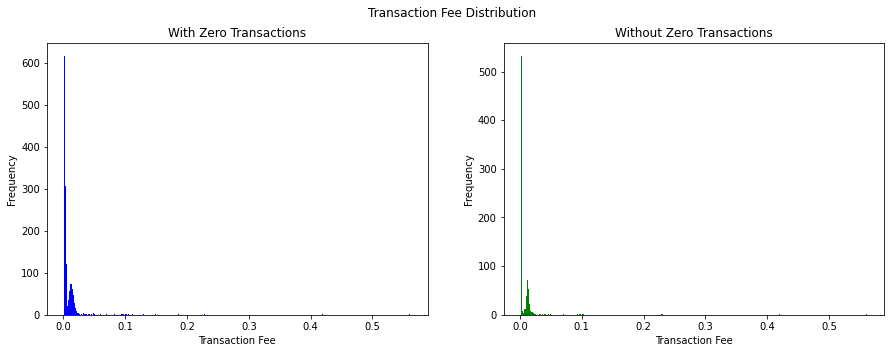

In [58]:
# 3.5 * standard deviation * n^(-1/3)
# bin_width_with_zero_txn = (3.5 * transactionsDf_with_zero_txn['Txn Fee'].std()) / (transactionsDf_with_zero_txn['Txn Fee'].count() ** (1/3))
# bin_size_with_zero_txn = round((transactionsDf_with_zero_txn['Txn Fee'].max() - transactionsDf_with_zero_txn['Txn Fee'].min()) / bin_width_with_zero_txn)

# bin_width_without_zero_txn = (3.5 * transactionsDf_without_zero_txn['Txn Fee'].std()) / (transactionsDf_without_zero_txn['Txn Fee'].count() ** (1/3))
# bin_size_without_zero_txn = round((transactionsDf_without_zero_txn['Txn Fee'].max() - transactionsDf_without_zero_txn['Txn Fee'].min()) / bin_width_without_zero_txn)

# #square root of the number of transactions
# bin_size_with_zero_txn = int(transactionsDf_with_zero_txn['Txn Fee'].count()** (1/2))
# bin_size_without_zero_txn = int(transactionsDf_without_zero_txn['Txn Fee'].count() ** (1/2))

# 2 * IQR * n^(-1/3)
bin_width_with_zero_txn = 2 * (transactionsDf_with_zero_txn['Txn Fee'].quantile(0.75) - transactionsDf_with_zero_txn['Txn Fee'].quantile(0.25)) * transactionsDf_with_zero_txn['Txn Fee'].count() ** (-1/3)
bin_width_without_zero_txn = 2 * (transactionsDf_without_zero_txn['Txn Fee'].quantile(0.75) - transactionsDf_without_zero_txn['Txn Fee'].quantile(0.25)) * transactionsDf_without_zero_txn['Txn Fee'].count() ** (-1/3)
bin_size_with_zero_txn = round((transactionsDf_with_zero_txn['Txn Fee'].max() - transactionsDf_with_zero_txn['Txn Fee'].min()) / bin_width_with_zero_txn)
bin_size_without_zero_txn = round((transactionsDf_without_zero_txn['Txn Fee'].max() - transactionsDf_without_zero_txn['Txn Fee'].min()) / bin_width_without_zero_txn)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution')

ax[0].hist(transactionsDf_with_zero_txn['Txn Fee'], bins=bin_size_with_zero_txn, color='blue')
ax[0].set_title('With Zero Transactions')
ax[0].set_xlabel('Transaction Fee')
ax[0].set_ylabel('Frequency')

ax[1].hist(transactionsDf_without_zero_txn['Txn Fee'], bins=bin_size_without_zero_txn, color='green')
ax[1].set_title('Without Zero Transactions')
ax[1].set_xlabel('Transaction Fee')
ax[1].set_ylabel('Frequency')

plt.show()


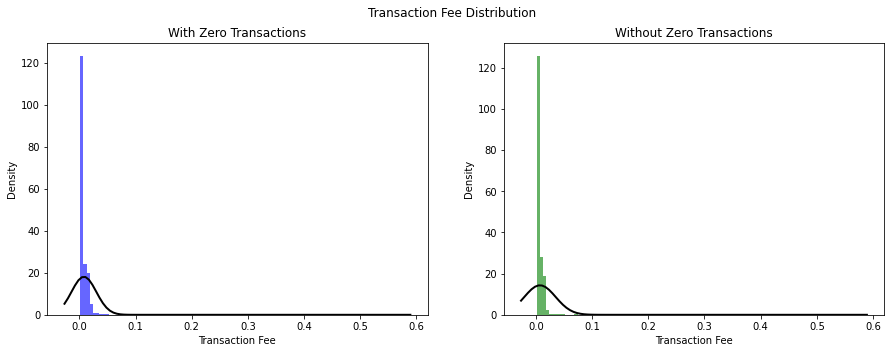

In [59]:

# 1 + log2(n) is the optimal number of bins
# bin_size_with_zero_txn = 1 + int(np.log2(transactionsDf_with_zero_txn['Txn Fee'].count()))
# bin_size_without_zero_txn = 1 + int(np.log2(transactionsDf_without_zero_txn['Txn Fee'].count()))

# fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# fig.suptitle('Transaction Fee Distribution')

# ax[0].hist(transactionsDf_with_zero_txn['Txn Fee'], bins=bin_size_with_zero_txn, color='blue')
# ax[0].set_title('With Zero Transactions')
# ax[0].set_xlabel('Transaction Fee')
# ax[0].set_ylabel('Frequency')

# ax[1].hist(transactionsDf_without_zero_txn['Txn Fee'], bins=bin_size_without_zero_txn, color='green')
# ax[1].set_title('Without Zero Transactions')
# ax[1].set_xlabel('Transaction Fee')
# ax[1].set_ylabel('Frequency')

# plt.show()

# 1 + log2(n) is the optimal number of bins
bin_width_with_zero_txn = 2 * (transactionsDf_with_zero_txn['Txn Fee'].quantile(0.75) - transactionsDf_with_zero_txn['Txn Fee'].quantile(0.25)) * transactionsDf_with_zero_txn['Txn Fee'].count() ** (-1/3)
bin_width_without_zero_txn = 2 * (transactionsDf_without_zero_txn['Txn Fee'].quantile(0.75) - transactionsDf_without_zero_txn['Txn Fee'].quantile(0.25)) * transactionsDf_without_zero_txn['Txn Fee'].count() ** (-1/3)
bin_size_with_zero_txn = round((transactionsDf_with_zero_txn['Txn Fee'].max() - transactionsDf_with_zero_txn['Txn Fee'].min()) / bin_width_with_zero_txn)
bin_size_without_zero_txn = round((transactionsDf_without_zero_txn['Txn Fee'].max() - transactionsDf_without_zero_txn['Txn Fee'].min()) / bin_width_without_zero_txn)

if bin_size_with_zero_txn > 50:
    bin_size_with_zero_txn = 100
if bin_size_without_zero_txn > 50:
    bin_size_without_zero_txn = 100

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution')

ax[0].hist(transactionsDf_with_zero_txn['Txn Fee'], bins=bin_size_with_zero_txn, color='blue', density=True, alpha=0.6)
ax[1].hist(transactionsDf_without_zero_txn['Txn Fee'], bins=bin_size_without_zero_txn, color='green', density=True, alpha=0.6)

mu1, std1 = norm.fit(transactionsDf_with_zero_txn['Txn Fee'])
mu2, std2 = norm.fit(transactionsDf_without_zero_txn['Txn Fee'])

xmin1, xmax1 = ax[0].get_xlim()
x1 = np.linspace(xmin1, xmax1, 100)
p1 = norm.pdf(x1, mu1, std1)
ax[0].plot(x1, p1, 'k', linewidth=2)

xmin2, xmax2 = ax[1].get_xlim()
x2 = np.linspace(xmin2, xmax2, 100)
p2 = norm.pdf(x2, mu2, std2)
ax[1].plot(x2, p2, 'k', linewidth=2)

ax[0].set_title('With Zero Transactions')
ax[0].set_xlabel('Transaction Fee')
ax[0].set_ylabel('Density')

ax[1].set_title('Without Zero Transactions')
ax[1].set_xlabel('Transaction Fee')
ax[1].set_ylabel('Density')

plt.show()

#### Plotting the Histogram of transaction fee using log transformation

In [60]:
def calcBinSize(df):
    bin_width = 2 * (df.quantile(0.75) - df.quantile(0.25)) * df.count() ** (-1/3)
    bin_size = round((df.max() - df.min()) / bin_width)
    if bin_size > 50:
        bin_size = 100
    return bin_size

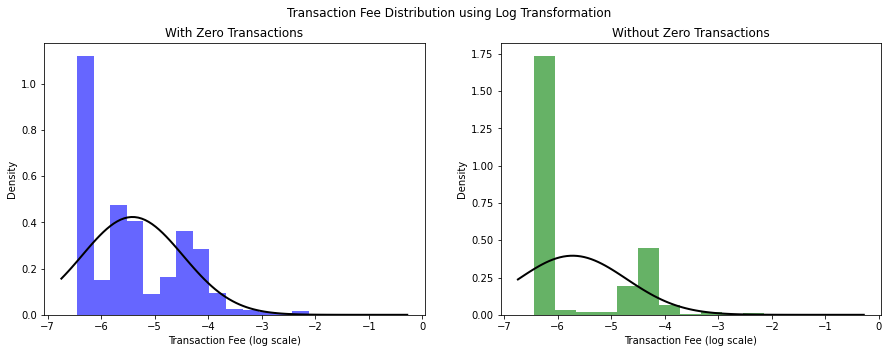

In [61]:
bin_size_with_zero_txn = calcBinSize(np.log(transactionsDf_with_zero_txn['Txn Fee']))
bin_size_without_zero_txn = calcBinSize(np.log(transactionsDf_without_zero_txn['Txn Fee']))
    
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution using Log Transformation')

ax[0].hist(np.log(transactionsDf_with_zero_txn['Txn Fee']), bins=bin_size_with_zero_txn, color='blue', density=True, alpha=0.6)
ax[1].hist(np.log(transactionsDf_without_zero_txn['Txn Fee']), bins=bin_size_without_zero_txn, color='green', density=True, alpha=0.6)

mu1, std1 = norm.fit(np.log(transactionsDf_with_zero_txn['Txn Fee']))
mu2, std2 = norm.fit(np.log(transactionsDf_without_zero_txn['Txn Fee']))

xmin1, xmax1 = ax[0].get_xlim()
x1 = np.linspace(xmin1, xmax1, 100)
p1 = norm.pdf(x1, mu1, std1)
ax[0].plot(x1, p1, 'k', linewidth=2)

xmin2, xmax2 = ax[1].get_xlim()
x2 = np.linspace(xmin2, xmax2, 100)
p2 = norm.pdf(x2, mu2, std2)
ax[1].plot(x2, p2, 'k', linewidth=2)

ax[0].set_title('With Zero Transactions')
ax[0].set_xlabel('Transaction Fee (log scale)')
ax[0].set_ylabel('Density')

ax[1].set_title('Without Zero Transactions')
ax[1].set_xlabel('Transaction Fee (log scale)')
ax[1].set_ylabel('Density')

plt.show()

Transaction Value Distribution

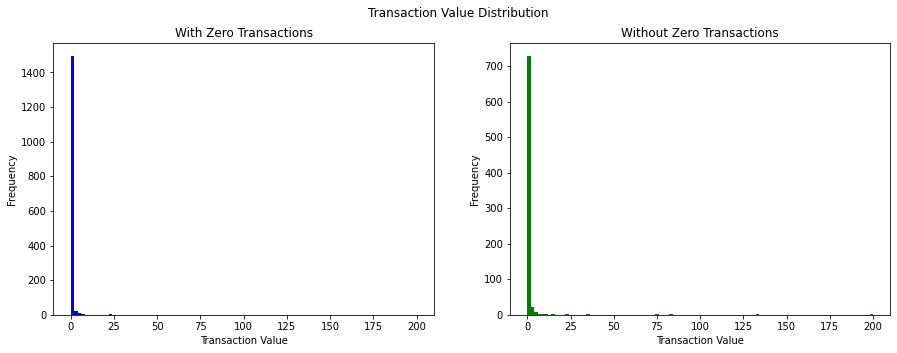

In [62]:

bin_size_with_zero_txn = calcBinSize(transactionsDf_with_zero_txn['Value'])
bin_size_without_zero_txn = calcBinSize(transactionsDf_without_zero_txn['Value'])

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Value Distribution')

ax[0].hist(transactionsDf_with_zero_txn['Value'], bins=bin_size_with_zero_txn, color='blue')
ax[0].set_title('With Zero Transactions')
ax[0].set_xlabel('Transaction Value')
ax[0].set_ylabel('Frequency')

ax[1].hist(transactionsDf_without_zero_txn['Value'], bins=bin_size_without_zero_txn, color='green')
ax[1].set_title('Without Zero Transactions')
ax[1].set_xlabel('Transaction Value')
ax[1].set_ylabel('Frequency')

plt.show()

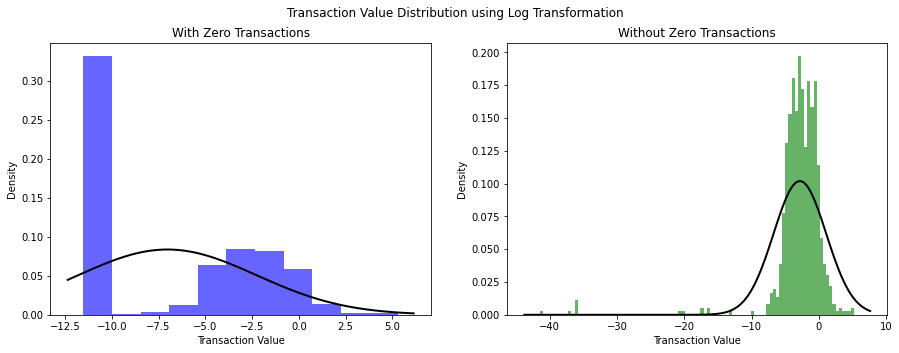

In [63]:
epsilon = 1e-5
tnx_with_epsilon_as_zero = transactionsDf_with_zero_txn['Value'] + epsilon
bin_size_with_zero_txn = calcBinSize(np.log(tnx_with_epsilon_as_zero))
bin_size_without_zero_txn = calcBinSize(np.log(transactionsDf_without_zero_txn['Value']))

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Value Distribution using Log Transformation')

ax[0].hist(np.log(tnx_with_epsilon_as_zero), bins=bin_size_with_zero_txn, color='blue', density=True, alpha=0.6)
ax[1].hist(np.log(transactionsDf_without_zero_txn['Value']), bins=bin_size_without_zero_txn, color='green', density=True, alpha=0.6)

mu1, std1 = norm.fit(np.log(tnx_with_epsilon_as_zero))
mu2, std2 = norm.fit(np.log(transactionsDf_without_zero_txn['Value']))

xmin1, xmax1 = ax[0].get_xlim()
x1 = np.linspace(xmin1, xmax1, 100)
p1 = norm.pdf(x1, mu1, std1)
ax[0].plot(x1, p1, 'k', linewidth=2)

xmin2, xmax2 = ax[1].get_xlim()
x2 = np.linspace(xmin2, xmax2, 100)
p2 = norm.pdf(x2, mu2, std2)
ax[1].plot(x2, p2, 'k', linewidth=2)

ax[0].set_title('With Zero Transactions')
ax[0].set_xlabel('Transaction Value')
ax[0].set_ylabel('Density')

ax[1].set_title('Without Zero Transactions')
ax[1].set_xlabel('Transaction Value')
ax[1].set_ylabel('Density')

plt.show()

### Box Plot

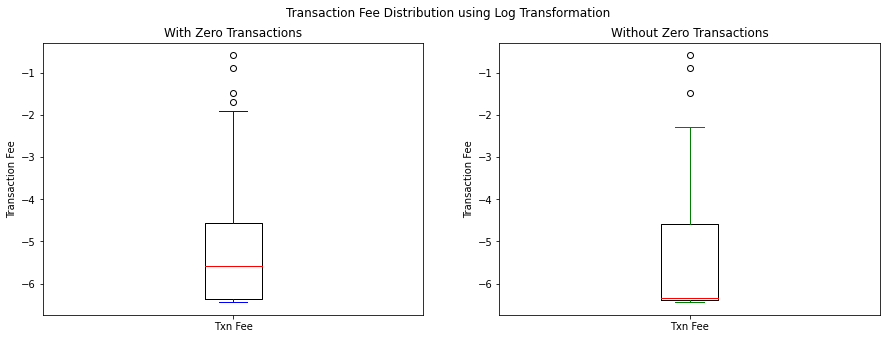

In [64]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution using Log Transformation')

boxplot1 = ax[0].boxplot(np.log(transactionsDf_with_zero_txn['Txn Fee']))
ax[0].set_title('With Zero Transactions')
ax[0].set_ylabel('Transaction Fee')
ax[0].set_xticklabels(['Txn Fee'])

boxplot2 = ax[1].boxplot(np.log(transactionsDf_without_zero_txn['Txn Fee']))
ax[1].set_title('Without Zero Transactions')
ax[1].set_ylabel('Transaction Fee')
ax[1].set_xticklabels(['Txn Fee'])

colors = ['blue', 'green']
for box, color in zip([boxplot1, boxplot2], colors):
    for whisker in box['whiskers']:
        whisker.set(color=color, linestyle='-')
    for cap in box['caps']:
        cap.set(color=color)
    for median in box['medians']:
        median.set(color='red')

plt.show()

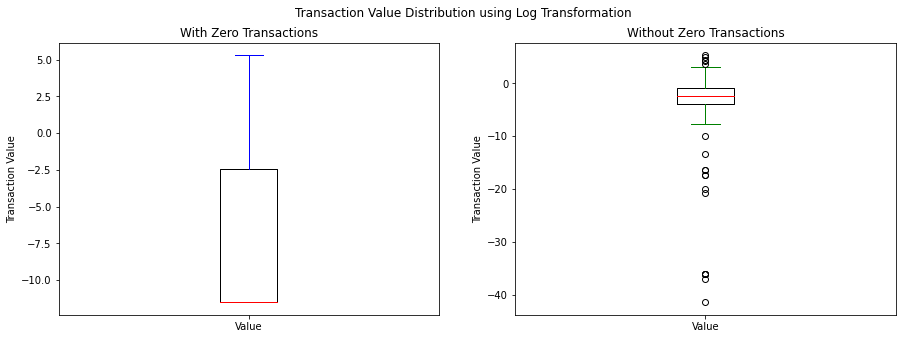

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Transaction Value Distribution using Log Transformation')

boxplot1 = ax[0].boxplot(np.log(tnx_with_epsilon_as_zero))
ax[0].set_title('With Zero Transactions')
ax[0].set_ylabel('Transaction Value')
ax[0].set_xticklabels(['Value'])

boxplot2 = ax[1].boxplot(np.log(transactionsDf_without_zero_txn['Value']))
ax[1].set_title('Without Zero Transactions')
ax[1].set_ylabel('Transaction Value')
ax[1].set_xticklabels(['Value'])

colors = ['blue', 'green']
for box, color in zip([boxplot1, boxplot2], colors):
    for whisker in box['whiskers']:
        whisker.set(color=color, linestyle='-')
    for cap in box['caps']:
        cap.set(color=color)
    for median in box['medians']:
        median.set(color='red')

plt.show()

### Violin Plot

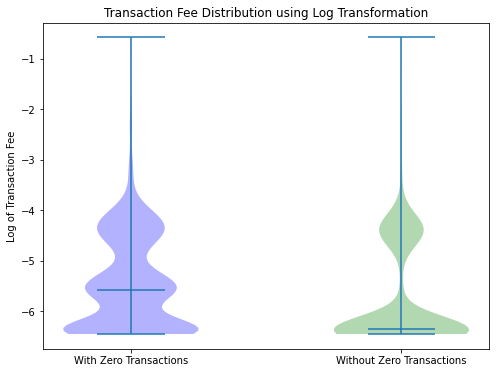

In [66]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Transaction Fee Distribution using Log Transformation')

violin_parts = ax.violinplot([np.log(transactionsDf_with_zero_txn['Txn Fee']), np.log(transactionsDf_without_zero_txn['Txn Fee'])], showmedians=True)

colors = ['blue', 'green']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)

ax.set_ylabel('Log of Transaction Fee')
ax.set_xticks([1, 2])
ax.set_xticklabels(['With Zero Transactions', 'Without Zero Transactions'])

plt.show()


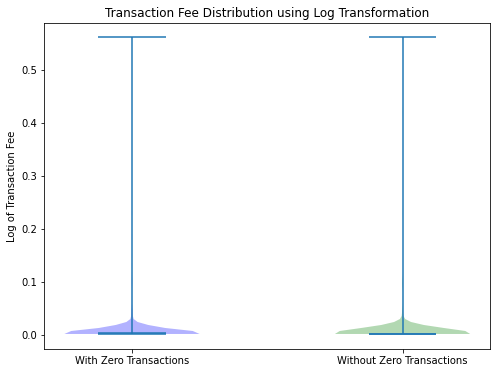

In [67]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Transaction Fee Distribution using Log Transformation')

violin_parts = ax.violinplot([transactionsDf_with_zero_txn['Txn Fee'], transactionsDf_without_zero_txn['Txn Fee']], showmedians=True)

colors = ['blue', 'green']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)

ax.set_ylabel('Log of Transaction Fee')
ax.set_xticks([1, 2])
ax.set_xticklabels(['With Zero Transactions', 'Without Zero Transactions'])

plt.show()

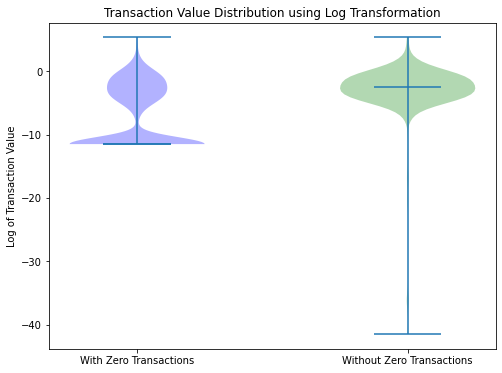

In [68]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Transaction Value Distribution using Log Transformation')

violin_parts = ax.violinplot([np.log(tnx_with_epsilon_as_zero), np.log(transactionsDf_without_zero_txn['Value'])], showmedians=True)

colors = ['blue', 'green']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)

ax.set_ylabel('Log of Transaction Value')
ax.set_xticks([1, 2])
ax.set_xticklabels(['With Zero Transactions', 'Without Zero Transactions'])

plt.show()

[Text(1, 0, 'With Zero Transactions'), Text(2, 0, 'Without Zero Transactions')]

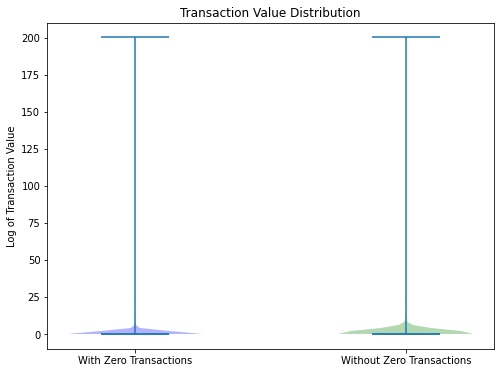

In [69]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Transaction Value Distribution')

violin_parts = ax.violinplot([transactionsDf_with_zero_txn['Value'], transactionsDf_without_zero_txn['Value']], showmedians=True)

colors = ['blue', 'green']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)

ax.set_ylabel('Log of Transaction Value')
ax.set_xticks([1, 2])
ax.set_xticklabels(['With Zero Transactions', 'Without Zero Transactions'])

## Sampling Data

The function uses a formula to determine the appropriate sample size based on the specified margin of error and confidence level. The function returns the calculated sample size as a proportion of the population size. If the calculated sample size is less than 20% of the population size, it returns 0.2 (20%) instead.  
`max(n/df.shape[0], 0.2)`: This line ensures that the calculated sample size is at least 20% of the population size. It's a way to prevent the sample size from being too small relative to the population size.

In [ ]:
def calcSampleProportion(df):
    z_score = 1.96
    margin_error = 0.05
    std_dev = df['Txn Fee'].std()
    numerator = ((z_score ** 2) * (std_dev * (1-std_dev))) / (margin_error ** 2)
    denominator = 1 + (((z_score ** 2) * (std_dev * (1-std_dev))) / ((margin_error ** 2) * (df.shape[0])))
    n = int(numerator / denominator)
    return max(n/df.shape[0], 0.2)

At first we will have a brief overview of the data and statistical summary of the data.

In [71]:
transactionsDf_with_zero_txn[['Value', 'Txn Fee']].describe()

,Value,Txn Fee
count,1.536000e+03,1536.000000
mean,5.809805e-01,0.008143
std,6.912997e+00,0.021964
min,0.000000e+00,0.001581
25%,0.000000e+00,0.001734
50%,1.565000e-16,0.003785
75%,8.595152e-02,0.010395
max,2.000458e+02,0.561137


### Simple Random Sampling (SRS)

We use the sample method to select a simple random sample from the DataFrame. We specify the sample size using the calculated sample size. We set the random_state parameter to 42 to ensure reproducibility. The statistical summary of the sample is also displayed.

In [72]:
sample_size = round(calcSampleProportion(transactionsDf_with_zero_txn) * transactionsDf_with_zero_txn.shape[0])
simple_random_sampled = transactionsDf_with_zero_txn.sample(n=sample_size, random_state=42)
display(simple_random_sampled[['Value', 'Txn Fee']].describe())

,Value,Txn Fee
count,307.000000,307.000000
mean,0.244091,0.008989
std,0.829338,0.026792
min,0.000000,0.001581
25%,0.000000,0.001739
50%,0.009088,0.003655
75%,0.122873,0.009641
max,10.000000,0.419933


### Stratified Sampling

For  stratified sampling, we use three characteristics to stratify the data: `Block', 'Method', and 'Value'. We calculate the sample size for each stratum using the formula for sample size calculation. We use the sample method to select a stratified random sample from the DataFrame. We specify the sample size for each stratum using the calculated sample size. The statistical summary of the sample is also displayed.

In [73]:
stratified_sampled_block = pd.DataFrame()

for method, group in transactionsDf_with_zero_txn.groupby('Block'):
    num_samples = round(len(group) * calcSampleProportion(transactionsDf_with_zero_txn))
    sampled_group = group.sample(n=num_samples, random_state=42)
    stratified_sampled = pd.concat([stratified_sampled, sampled_group])

stratified_sampled_block[['Value', 'Txn Fee']].describe()

According to numerous values for 'Method', we decided to use top 9 most frequent values for 'Method' and group the rest of the values into 'Other' category. In order not to lose the information of 'Method' column, we added a new column named 'New Method' to the DataFrame.

In [74]:
transactionsDf_with_zero_txn['New Method'] = transactionsDf_with_zero_txn['Method']
transactionsDf_with_zero_txn

,Txn Hash,Method,Block,Value,Txn Fee,New Methods
0,0x78d28539fa6bafafa693ab3e88f0d69f1d76b7309e09...,Transfer,19398639,0.055852,0.001663,Transfer
1,0x51139f42abe61475f05b79f25047fd0917769de90ba6...,Approve,19398639,0.000000,0.002176,Approve
2,0x05ce599999a91a027f57148b0414e359a4d188af2cd5...,Approve,19398639,0.000000,0.003629,Approve
3,0x55fcc20c69b7313ef26f629f4e09cf9686edcf73dc63...,Approve,19398639,0.000000,0.003486,Approve
4,0x2c728c6597cc9e113b1711beccebf13d35ac53ccc362...,Transfer,19398639,0.050000,0.001581,Transfer
...,...,...,...,...,...,...
2448,0x2d2744121c928d3d9684bc2e70ce755222a7cbee68ac...,0x02000000,19398630,0.000000,0.017541,0x02000000
2449,0x0cf976f4016ade110d42d0b1a143571feba3b3213195...,Sell To Uniswap,19398630,0.585649,0.010208,Sell To Uniswap
2450,0x0452398faafd349a4aa4634985cbd8289672e7982abf...,0x01000000,19398630,0.000000,0.008736,0x01000000
2451,0x26e4a5ff58dc49b05776348d3bf64c396b204b7d7003...,Execute,19398630,0.000000,0.014265,Execute


The DataFrame is grouped by the 'New Method' column using groupby(). For each group (method), the number of samples to be taken is calculated based on the proportion returned by calcSampleProportion(). The sample method is used to select a stratified random sample from the DataFrame. The statistical summary of the sample is also displayed.

In [75]:
stratified_sampled = pd.DataFrame()

top_9_methods = transactionsDf_with_zero_txn['New Method'].value_counts().nlargest(9).index
transactionsDf_with_zero_txn.loc[~transactionsDf_with_zero_txn['New Method'].isin(top_9_methods), 'New Method'] = 'Other'

for method, group in transactionsDf_with_zero_txn.groupby('New Method'):
    num_samples = round(len(group) * calcSampleProportion(transactionsDf_with_zero_txn))
    sampled_group = group.sample(n=num_samples, random_state=42)
    stratified_sampled = pd.concat([stratified_sampled, sampled_group])

stratified_sampled[['Value', 'Txn Fee']].describe()

,Value,Txn Fee
count,307.000000,307.000000
mean,0.254304,0.008862
std,1.423720,0.020106
min,0.000000,0.001581
25%,0.000000,0.001753
50%,0.000000,0.003824
75%,0.078249,0.010534
max,22.626700,0.229372


The DataFrame is grouped by the 'Value' column using 'groupby()'. For each group (value range), the number of samples to be taken is calculated based on the proportion of that range in the population. The sample method is used to select a stratified random sample from the DataFrame. The statistical summary of the sample is also displayed.

In [76]:
stratified_sampled_value = pd.DataFrame()
stratified_sampled_value = transactionsDf_with_zero_txn.groupby('Value', group_keys=False).apply(lambda x: x.sample(frac=calcSampleProportion(transactionsDf_with_zero_txn), random_state=42))

stratified_sampled_value[['Value', 'Txn Fee']].describe()

The code below visually compares the distribution of transaction fees between the original data, a stratified sample, and a simple random sample using histograms. The logarithm transformation is applied to the transaction fees for better visualization. Using Log transformation is a common practice when dealing with data that has many values that are close to zero. It helps to make the data more interpretable and easier to visualize.

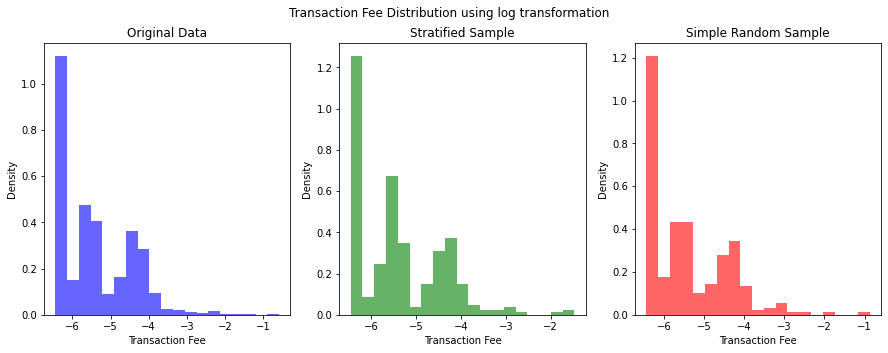

In [77]:
bin_size_original = calcBinSize(np.log(transactionsDf_with_zero_txn['Txn Fee']))
bin_size_stratified = bin_size_original
bin_size_simple = bin_size_original

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution using log transformation')

ax[0].hist(np.log(transactionsDf_with_zero_txn['Txn Fee']), bins=bin_size_original, color='blue', density=True, alpha=0.6)
ax[0].set_title('Original Data')
ax[0].set_xlabel('Transaction Fee')
ax[0].set_ylabel('Density')

ax[1].hist(np.log(stratified_sampled['Txn Fee']), bins=bin_size_stratified, color='green', density=True, alpha=0.6)
ax[1].set_title('Stratified Sample')
ax[1].set_xlabel('Transaction Fee')
ax[1].set_ylabel('Density')

ax[2].hist(np.log(simple_random_sampled['Txn Fee']), bins=bin_size_simple, color='red', density=True, alpha=0.6)
ax[2].set_title('Simple Random Sample')
ax[2].set_xlabel('Transaction Fee')
ax[2].set_ylabel('Density')

plt.show()

As we can see from the above plots, the stratified sample and simple random sample have a similar distribution to the original data. This is because the sample size is large enough to capture the distribution of the original data. The stratified sample has a similar distribution to the original data, but it is more representative of the population because it captures the distribution of the original data for each stratum. The simple random sample also captures the distribution of the original data, but it may not be as representative of the population as the stratified sample because it may not capture the distribution of the original data for each stratum.

As the calculation of Log 0 is undefined, we need to use a small value to replace 0 in the data. We use the epsilon value to replace 0 in the data. The epsilon value is a small positive number that is added to the data to avoid taking the logarithm of 0. 

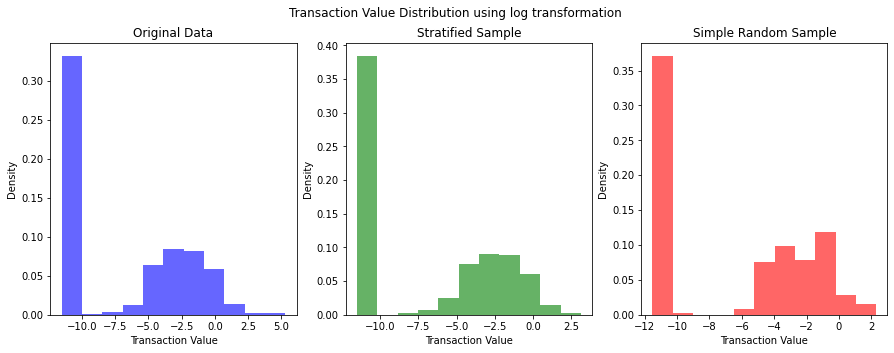

In [78]:
stratified_sampled_plus_epsilon = stratified_sampled['Value'] + epsilon
transactionsDf_with_zero_txn_plus_epsilon = transactionsDf_with_zero_txn['Value'] + epsilon
simple_random_sampled_plus_epsilon = simple_random_sampled['Value'] + epsilon

bin_size_original = calcBinSize(np.log(transactionsDf_with_zero_txn_plus_epsilon))
bin_size_stratified = bin_size_original
bin_size_simple = bin_size_original

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Transaction Value Distribution using log transformation')

ax[0].hist(np.log(transactionsDf_with_zero_txn_plus_epsilon), bins=bin_size_original, color='blue', density=True, alpha=0.6)
ax[0].set_title('Original Data')
ax[0].set_xlabel('Transaction Value')
ax[0].set_ylabel('Density')

ax[1].hist(np.log(stratified_sampled_plus_epsilon), bins=bin_size_stratified, color='green', density=True, alpha=0.6)
ax[1].set_title('Stratified Sample')
ax[1].set_xlabel('Transaction Value')
ax[1].set_ylabel('Density')

ax[2].hist(np.log(simple_random_sampled_plus_epsilon), bins=bin_size_simple, color='red', density=True, alpha=0.6)
ax[2].set_title('Simple Random Sample')
ax[2].set_xlabel('Transaction Value')
ax[2].set_ylabel('Density')

plt.show()

As we can see from the above plots, the result for the 'Value' column is similar to the result for the 'Tnx Fee' column. 

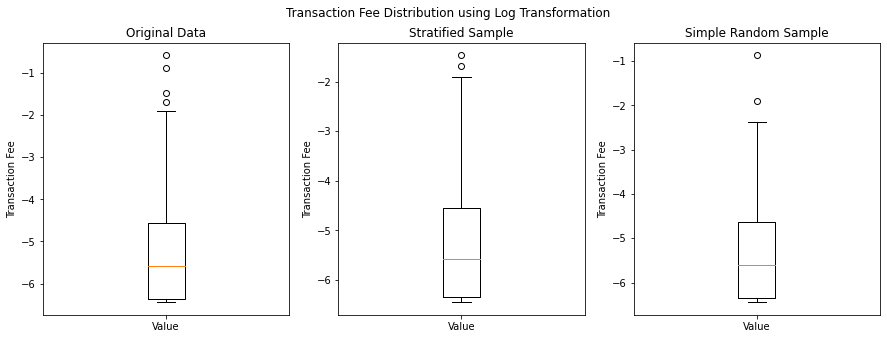

In [79]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Transaction Fee Distribution using Log Transformation')

boxplot1 = ax[0].boxplot(np.log(transactionsDf_with_zero_txn['Txn Fee']))
ax[0].set_title('Original Data')
ax[0].set_ylabel('Transaction Fee')
ax[0].set_xticklabels(['Value'])

boxplot2 = ax[1].boxplot(np.log(stratified_sampled['Txn Fee']))
ax[1].set_title('Stratified Sample')
ax[1].set_ylabel('Transaction Fee')
ax[1].set_xticklabels(['Value'])

boxplot3 = ax[2].boxplot(np.log(simple_random_sampled['Txn Fee']))
ax[2].set_title('Simple Random Sample')
ax[2].set_ylabel('Transaction Fee')
ax[2].set_xticklabels(['Value'])

plt.show()

By interpreting these elements of the box plot, we can gain insights into the central tendency, spread, and distribution of the dataset, as well as identify potential outliers or anomalies. As we expected, the median value of the stratified and simple random samples are similar to the median value of the original data. 

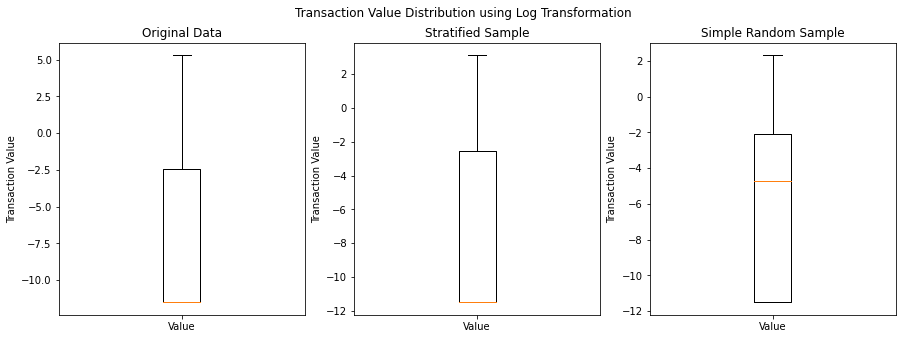

In [80]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Transaction Value Distribution using Log Transformation')

boxplot1 = ax[0].boxplot(np.log(transactionsDf_with_zero_txn_plus_epsilon))
ax[0].set_title('Original Data')
ax[0].set_ylabel('Transaction Value')
ax[0].set_xticklabels(['Value'])

boxplot2 = ax[1].boxplot(np.log(stratified_sampled_plus_epsilon))
ax[1].set_title('Stratified Sample')
ax[1].set_ylabel('Transaction Value')
ax[1].set_xticklabels(['Value'])

boxplot3 = ax[2].boxplot(np.log(simple_random_sampled_plus_epsilon))
ax[2].set_title('Simple Random Sample')
ax[2].set_ylabel('Transaction Value')
ax[2].set_xticklabels(['Value'])

plt.show()

As we can see from the above plots, the result for the 'Value' column for Stratified is more similar to the original data than the result for Simple Random Sample.

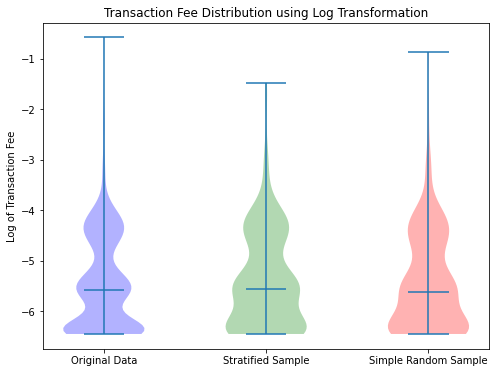

In [81]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Transaction Fee Distribution using Log Transformation')

violin_parts = ax.violinplot([np.log(transactionsDf_with_zero_txn['Txn Fee']), np.log(stratified_sampled['Txn Fee']), np.log(simple_random_sampled['Txn Fee'])], showmedians=True)
colors = ['blue', 'green', 'red']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)

ax.set_ylabel('Log of Transaction Fee')
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Original Data', 'Stratified Sample', 'Simple Random Sample'])

plt.show()

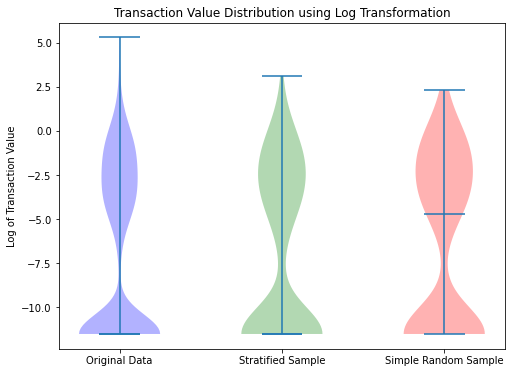

In [82]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title('Transaction Value Distribution using Log Transformation')

violin_parts = ax.violinplot([np.log(transactionsDf_with_zero_txn_plus_epsilon), np.log(stratified_sampled_plus_epsilon), np.log(simple_random_sampled_plus_epsilon)], showmedians=True)
colors = ['blue', 'green', 'red']
for pc, color in zip(violin_parts['bodies'], colors):
    pc.set_facecolor(color)

ax.set_ylabel('Log of Transaction Value')
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Original Data', 'Stratified Sample', 'Simple Random Sample'])

plt.show()

In [1]:
original_df = transactionsDf_with_zero_txn[['Value', 'Txn Fee']].describe().T[['mean', 'std']]
stratified_df = stratified_sampled[['Value', 'Txn Fee']].describe().T[['mean', 'std']]
simple_random_df = simple_random_sampled[['Value', 'Txn Fee']].describe().T[['mean', 'std']]
stratified_df_value = stratified_sampled_value[['Value', 'Txn Fee']].describe().T[['mean', 'std']]
stratified_df_block = stratified_sampled_block[['Value', 'Txn Fee']].describe().T[['mean', 'std']]

combined_stats = pd.concat([original_df, stratified_df, stratified_df_value, stratified_df_block,  simple_random_df], axis=0, keys=['Original', 'Stratified Method', 'Stratified Value', 'Stratified Block', 'Simple Random Sample'])

print(combined_stats)

NameError: name 'transactionsDf_with_zero_txn' is not defined